In [1]:
import Pkg; Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [7]:
using CSV
using Plots
using DataFrames
using Statistics
using ScikitLearn
using ScikitLearn.CrossValidation: train_test_split
using StatsBase: countmap


In [8]:

@sk_import metrics: (accuracy_score, confusion_matrix)
@sk_import ensemble: AdaBoostClassifier
@sk_import tree: DecisionTreeClassifier

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment
Could not load conda plugin `conda-libmamba-solver`:

dlopen(/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/bindings.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libarchive.13.dylib
  Referenced from: <A1C11063-2162-3BE9-8EB8-234003BCB9E4> /Users/mandarangchekar/.julia/conda/3/aarch64/lib/libmamba.2.0.0.dylib
  Reason: tried: '/Users/mandarangchekar/.julia/conda/3/aarch64/lib/libarchive.13.dylib' (no such file), '/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.13.dylib' (no such file), '/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.13.dylib' (no such file), '/Users/mandarangchekar/.julia/conda/3/aarch64/bin/../lib/libarchive.13.dylib'

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0




PyObject <class 'sklearn.tree._classes.DecisionTreeClassifier'>

In [9]:


# Your existing code for loading and preprocessing data
data = CSV.File("71-80.csv") |> DataFrame

function normalize(df::AbstractDataFrame, cols::Vector{<:AbstractString})
    means = mean.(eachcol(df[:, cols]))
    stds = std.(eachcol(df[:, cols]))
    means_matrix = repeat(means', nrow(df), 1)
    stds_matrix = repeat(stds', nrow(df), 1)
    return (df[:, cols] .- means_matrix) ./ stds_matrix
end

data[:, "ratio"] = data[:, "cit_2022"] ./ data[:, "cit_2021"]
data[:, "category"] = ifelse.(data[:, "ratio"] .< 1.05, 1, ifelse.(data[:, "ratio"] .< 1.15, 2, 3))
X_normalized = normalize(data, ["cit_2017", "cit_2018", "cit_2019", "cit_2020", "cit_2021", "cit_2022"])
X_matrix = Matrix(X_normalized)
y_vector = Vector(data[:, "category"])
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_vector, test_size=0.2, random_state=42)


4-element Vector{Array}:
 [-0.4554573987855993 -0.4862973757667193 … -0.45562961148986064 -0.4243100734177345; -0.5841811712654914 -0.6286398875774509 … -0.6883104003996909 -0.7079275704195408; … ; -0.10810753653827136 -0.21940516612159733 … -0.46301630320128384 -0.5359272819152195; -0.24909071592101037 -0.30639225667260006 … -0.4094627882934657 -0.42613986372097196]
 [-0.5310570746864883 -0.5436297763571529 … -0.6310635396361612 -0.6548636516256544; -0.47384650913986964 -0.31627715332612305 … 0.3107396535702948 0.5253510939625071; … ; -0.2613501228238572 -0.24905985608216644 … -0.1380018678986637 -0.19558628551305204; 0.44356577408983777 0.41718217836528615 … 0.42338670216949836 0.44301053031682136]
 [3, 1, 3, 1, 3, 3, 1, 1, 1, 3  …  3, 1, 1, 1, 1, 1, 1, 2, 1, 1]
 [1, 3, 3, 1, 1, 3, 3, 2, 3, 1, 1, 3, 1, 1, 3, 3, 2, 1, 1, 1]

In [10]:

# AdaBoost implementation
# model = AdaBoostClassifier(n_estimators=70)

model = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=2),
    learning_rate=0.01,
    n_estimators=100
)
# for an accuracy of 0.65

fit!(model, X_train, y_train)

# Predicting and evaluating the model
y_pred = predict(model, X_test)
accuracy = mean(y_pred .== y_test)
println("Test Accuracy: $accuracy")


Test Accuracy: 0.65


/Users/mandarangchekar/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


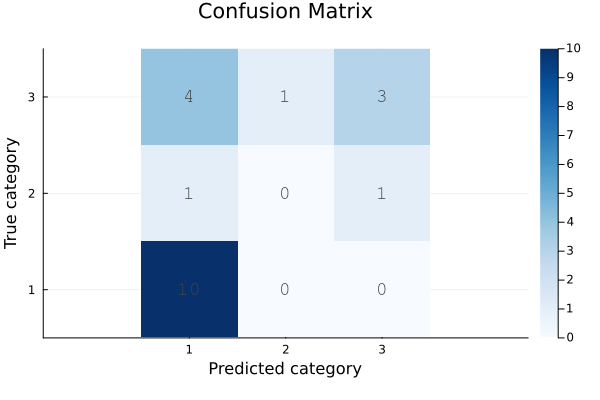

GKS: could not find font middle.ttf


In [11]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
categories = sort(unique(y_vector))
plt = heatmap(cm, color=:Blues, xlabel="Predicted category", ylabel="True category", title="Confusion Matrix",
              xticks=(1:length(categories), categories), yticks=(1:length(categories), categories), aspect_ratio=:equal)

for (i, actual_category) in enumerate(categories)
    for (j, predicted_category) in enumerate(categories)
        annotate!(plt, j, i, text(string(cm[i, j]), :center, :middle, 10))
    end
end

display(plt)